# semopy Tutorial: A Minimal CFA Demo (Step-by-Step)

This notebook demonstrates a compact workflow for Structural Equation Modeling (SEM) with semopy.

We will:
1. Simulate a small dataset for a one-factor Confirmatory Factor Analysis (CFA).
2. Specify the model in lavaan-like syntax.
3. Fit the model and inspect results.
4. Compute basic fit statistics.
5. Draw a simple path diagram resembling the style used in the `bollen_semopy.ipynb` workbook.


In [1]:
# Imports and environment report
from __future__ import annotations
import os
import numpy as np
import pandas as pd
import semopy
from semopy import Model

print('numpy:', np.__version__)
print('pandas:', pd.__version__)
print('semopy:', semopy.__version__)
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')


numpy: 2.3.3
pandas: 2.3.2
semopy: 2.3.11


## 1) Simulate data and specify a one-factor CFA model

We simulate three observed indicators `y1`, `y2`, `y3` loading on a single latent factor `eta`.
The model fixes the variance of `eta` to 1 for identification.


In [2]:
import pandas as pd
import numpy as np

def build_sample_data(n: int = 120, seed: int = 7) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    eta = rng.normal(size=n)  # latent factor with variance ~ 1
    y1 = 0.8 * eta + rng.normal(scale=0.6, size=n)
    y2 = 0.9 * eta + rng.normal(scale=0.5, size=n)
    y3 = 0.7 * eta + rng.normal(scale=0.7, size=n)
    return pd.DataFrame({'y1': y1, 'y2': y2, 'y3': y3})

# Model specification (lavaan-like syntax)
MODEL_SPEC = '''
# Measurement model
eta =~ y1 + y2 + y3

# Fix latent variance to 1 for identifiability
eta ~~ 1*eta
'''

data = build_sample_data()
data.head()


,y1,y2,y3
0,0.0546,-0.2290,0.3533
1,-0.1156,0.6405,1.5187
2,-0.2905,-0.2880,0.2225
3,-1.9111,-0.7610,-0.5843
4,-1.0426,-0.5546,-1.4986


## 2) Fit the model

We instantiate `semopy.Model` with the specification string and fit it to the simulated data.


In [3]:
model = Model(MODEL_SPEC)
res = model.fit(data)
print('Fit done. Result type:', type(res).__name__)


Fit done. Result type: SolverResult


## 3) Inspect estimates and fit statistics

Below we display the parameter table and selected fit indices (if available for your version of semopy).


In [4]:
# Estimates table
try:
    estimates = model.inspect()
except Exception:
    estimates = semopy.inspect(model) if hasattr(semopy, 'inspect') else None
print(estimates)

# Fit statistics
stats = None
try:
    stats = model.calc_stats() if hasattr(model, 'calc_stats') else semopy.calc_stats(model)
except TypeError:
    try:
        stats = semopy.calc_stats(model, data)
    except Exception:
        stats = None
print(stats)


  lval  op rval  Estimate Std. Err z-value p-value
0   y1   ~  eta    1.0000        -       -       -
1   y2   ~  eta    0.6960   0.0711  9.7933  0.0000
2   y3   ~  eta    0.7717   0.0791  9.7621  0.0000
3  eta  ~~  eta    1.0000        -       -       -
4   y1  ~~   y1    0.1558   0.0727  2.1420  0.0322
5   y2  ~~   y2    0.3500   0.0579  6.0425  0.0000
6   y3  ~~   y3    0.4354   0.0717  6.0689  0.0000
       DoF  DoF Baseline   chi2  chi2 p-value  chi2 Baseline    CFI    GFI  \
Value    1             3 8.2918        0.0040       127.6570 0.9415 0.9350   

        AGFI    NFI    TLI  RMSEA    AIC     BIC  LogLik  
Value 0.8051 0.9350 0.8245 0.2475 9.8618 23.7993  0.0691  


### Interpreting the estimates and fit indices (Section 3)

- Parameter table columns:
  - lval: Left-hand variable (left side of the lavaan-style statement).
  - op: Operator indicating the relation type. Common values:
    - =~ (measurement/loading): latent factor on left, indicator on right.
    - ~ (regression/structural path): dependent variable on left, predictor(s) on right.
    - ~~ (variance/covariance): variance if lval == rval; covariance otherwise.
  - rval: Right-hand variable (right side of the statement).
  - Estimate: Point estimate of the parameter (loading, regression coefficient, variance, or covariance).
  - Std. Err: Standard error of the estimate.
  - z-value: Wald statistic, Estimate / Std. Err, testing H0: parameter = 0.
  - p-value: Two-sided p-value for the z-test (vs. 0).

- What are lval and rval?
  - For a loading row (eta =~ y1), lval = eta, op = =~, rval = y1. The Estimate is the loading of y1 on eta.
  - For a variance row (y1 ~~ y1), lval = y1, op = ~~, rval = y1. The Estimate is Var(y1)'s residual variance.
  - For the latent variance constraint (eta ~~ 1*eta), the model fixes Var(eta) = 1 (not estimated).

- Why do the estimated loadings differ from the generative values (0.8, 0.9, 0.7)?
  - Sampling variability: We generated one finite sample (n = 120). Even with a correctly specified model, estimates fluctuate around population values, and may deviate noticeably in a single sample.
  - Identification/sign indeterminacy: The factor’s sign is arbitrary. If the algorithm flips the factor sign, all loadings flip sign together; the model fit is identical. Compare magnitudes, not signs.
  - Estimation target: ML estimates are chosen to reproduce the sample covariance matrix as well as possible; with finite samples the sample covariances differ from population values.
  - Bias at small n: With modest n, small finite-sample bias can occur. Re-running with larger n will typically bring estimates closer to the generating values.
  - Note: The z-values and p-values test whether a parameter differs from zero, not whether it equals the generating value. Large |z| means the loading is reliably nonzero.

- Fit statistics shown (availability can vary by semopy version):
  - DoF: Model degrees of freedom = number of unique elements in the observed covariance matrix minus the number of free parameters. Larger DoF implies more testable restrictions.
  - DoF Baseline: Degrees of freedom for the baseline (independence) model where variables are uncorrelated.
  - chi2: Model chi-square test statistic assessing exact fit (H0: model-implied covariance equals population). Smaller is better.
  - chi2 p-value: p-value for chi2. A large p (e.g., > .05) suggests no evidence against exact fit; small p indicates misfit. This test is sensitive to n.
  - chi2 Baseline: Chi-square of the baseline independence model (should be large if variables are strongly related).
  - CFI: Comparative Fit Index; compares model vs. baseline improvement. Values close to 1 indicate good fit; common heuristics use >= .95 as strong, >= .90 as acceptable.
  - GFI: Goodness-of-Fit Index; proportion of covariance explained by the model (0–1), with higher being better (interpret with caution; it can be sample-size sensitive).

- Comment on expected fit quality here:
  - Because the data were simulated from the one-factor model we fit, we typically expect excellent fit: very high CFI (≈ .97–1.00), high GFI (≈ .95–1.00), relatively small chi2 with a non-significant p-value (though chi2 can still be significant with some random draws or larger n). If indices depart from these ranges, it is due to sample randomness at n = 120.

- About the specific example (e.g., chi2 = 8.2918, chi2 p-value = 0.0040, chi2 Baseline = 127.6570):
  - How do we conclude a “low” chi-square? Low is judged relative to the baseline (independence) model and to the model’s degrees of freedom (DoF). Here, the baseline chi2 is very large (≈ 127.7), so our model reduces misfit dramatically to ≈ 8.3, which is small in absolute terms and tiny relative to the baseline. This is consistent with good relative fit indices (e.g., high CFI).
  - Why is the chi-square p-value close to 0? The chi2 p-value tests exact fit (H0: the model-implied covariance equals the population covariance exactly). With finite samples, even tiny deviations from exact fit can yield a statistically significant chi2, especially as sample size grows because chi2 roughly scales with n. Thus, you can see a small absolute chi2 yet a small p-value. This is a known sensitivity of the exact-fit test and is why practitioners also report approximate-fit indices (CFI/TLI, RMSEA, SRMR).
  - Should we worry? Focus on a suite of indices. A small p-value alone does not necessarily imply practically important misfit when other indices indicate excellent fit and residuals are small.

- If we change the sample size (e.g., from n = 120 to n = 129), will the results “improve”?
  - Parameter estimates: Precision generally improves with larger n (standard errors shrink), so estimates will be more stable across samples.
  - Chi-square and its p-value: For the exact-fit test, chi2 tends to increase with n (greater power to detect tiny misfit), so the p-value often becomes even smaller (appearing to “worsen”). Thus, by the chi2 p-value criterion, increasing n may not look like an improvement.
  - Relative/approximate fit indices (CFI, TLI, RMSEA, SRMR): These usually remain similar if the model is correctly specified; RMSEA may even decrease slightly with better precision, though behavior depends on DoF and sample peculiarities.
  - Bottom line: Larger n improves estimation precision but can make the exact-fit chi2 test more likely to reject. Judge fit using multiple indices and substantive plausibility, not the chi2 p-value alone.


## 4) Visualize the path diagram (Graphviz preferred)

We parse the `MODEL_SPEC` string to extract nodes and edges and draw a diagram.
If Graphviz (Python package and `dot` executable) is available, we use it to lay out the
nodes (ellipses for latents, boxes for observed) and edges (directed for loadings/paths;
curved double-headed arrows for covariances). Otherwise, we fall back to matplotlib.


Graphviz Python package: available
Graphviz 'dot' executable: found at /opt/homebrew/bin/dot


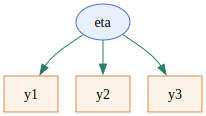

Diagram saved: /Volumes/mybook2/BOOK_REVISION/chapter04/sem/bollen_semopy_report/plot/semopy_demo_model.png


'/Volumes/mybook2/BOOK_REVISION/chapter04/sem/bollen_semopy_report/plot/semopy_demo_model.png'

In [5]:
import os, shutil
from importlib import util as _util

# Parse MODEL_SPEC to determine nodes and edges
meas_edges, struct_edges, covar_pairs = [], [], []
latents, observed = set(), set()
for line in MODEL_SPEC.splitlines():
    s = line.strip()
    if not s or s.startswith('#'):
        continue
    if '=~' in s:
        lhs, rhs = [t.strip() for t in s.split('=~', 1)]
        latents.add(lhs)
        for p in [p.strip() for p in rhs.split('+') if p.strip()]:
            if '*' in p:
                p = p.split('*', 1)[-1].strip()
            meas_edges.append((lhs, p))
            observed.add(p)
    elif '~~' in s:  # residual covariance / correlation
        a, b = [t.strip() for t in s.split('~~', 1)]
        covar_pairs.append(tuple(sorted((a, b))))
    elif '~' in s and '~~' not in s:
        lhs, rhs = [t.strip() for t in s.split('~', 1)]
        for p in [p.strip() for p in rhs.split('+') if p.strip()]:
            if '*' in p:
                p = p.split('*', 1)[-1].strip()
            struct_edges.append((p, lhs))  # p -> lhs
            if lhs not in observed:
                latents.add(lhs)
            if p not in observed:
                latents.add(p)

# Output path
plot_dir = os.path.join(os.getcwd(), 'bollen_semopy_report', 'plot')
os.makedirs(plot_dir, exist_ok=True)
base_name = 'semopy_demo_model'
save_path = os.path.join(plot_dir, base_name + '.png')

# Try Graphviz first
has_graphviz_pkg = _util.find_spec('graphviz') is not None
dot_path = shutil.which('dot')
print(f"Graphviz Python package: {'available' if has_graphviz_pkg else 'NOT available'}")
print(f"Graphviz 'dot' executable: {'found at ' + dot_path if dot_path else 'NOT found in PATH'}")

shown = False
if has_graphviz_pkg and dot_path:
    try:
        from graphviz import Digraph
        g = Digraph('SemopyDemo', format='png')
        g.attr(rankdir='TB', splines='curved')
        # Nodes
        for l in sorted(latents):
            g.node(l, shape='ellipse', style='filled', fillcolor='#e8f0fe', color='#4a70d3')
        for o in sorted(observed):
            g.node(o, shape='box', style='filled', fillcolor='#fef3e8', color='#d38b4a')
        # Edges
        for a, b in meas_edges:
            g.edge(a, b, color='#2a7f62')
        for a, b in struct_edges:
            g.edge(a, b, color='#7f2a5a')
        # Covariance (curved, double-headed) edges if any
        for a, b in sorted(set(covar_pairs)):
            # show only between observed variables for clarity
            if a in observed and b in observed:
                g.edge(a, b, dir='both', arrowhead='vee', arrowtail='vee', color='#444444', constraint='false')
        # Save and optionally display
        g.render(filename=base_name, directory=plot_dir, cleanup=True)
        try:
            from importlib import import_module as _import_module
            _ip = _import_module('IPython.display')
            _ip.display(g)
        except Exception:
            pass
        print(f"Diagram saved: {save_path}")
        shown = True
    except Exception as e:
        print('Graphviz rendering failed, falling back to matplotlib:', e)

if not shown:
    # Matplotlib fallback
    import matplotlib.pyplot as plt
    from matplotlib.patches import FancyArrowPatch, Ellipse
    # Simple layout: latents on top row, observed bottom row
    latents_list = sorted(latents)
    observed_list = sorted(observed)
    nL, nO = len(latents_list), len(observed_list)
    pos = {}
    for i, node in enumerate(latents_list):
        pos[node] = (i if nL <= 1 else i / (nL - 1), 1.0)
    for i, node in enumerate(observed_list):
        pos[node] = (i if nO <= 1 else i / (nO - 1), 0.0)

    fig, ax = plt.subplots(figsize=(6, 4))
    for node, (x, y) in pos.items():
        is_latent = node in latents
        if is_latent:
            e = Ellipse((x, y), width=0.22, height=0.16,
                        facecolor='#e8f0fe', edgecolor='#4a70d3', linewidth=1.2)
            ax.add_patch(e)
            ax.text(x, y, node, ha='center', va='center', color='black')
        else:
            box_style = dict(boxstyle='square', fc='#fef3e8', ec='#d38b4a', lw=1.2)
            ax.text(x, y, node, ha='center', va='center', bbox=box_style)

    def _arrow(a, b, color):
        xa, ya = pos[a]; xb, yb = pos[b]
        ax.annotate('', xy=(xb, yb), xytext=(xa, ya),
                    arrowprops=dict(arrowstyle='->', color=color, lw=1.6))

    for a, b in meas_edges:
        _arrow(a, b, '#2a7f62')
    for a, b in struct_edges:
        _arrow(a, b, '#7f2a5a')

    def _cov(a, b, color='#444444', rad=0.25):
        if a not in pos or b not in pos:
            return
        xa, ya = pos[a]; xb, yb = pos[b]
        r = rad if xa <= xb else -rad
        patch = FancyArrowPatch((xa, ya), (xb, yb),
                                connectionstyle=f"arc3,rad={r}",
                                arrowstyle='<->', color=color, lw=1.4,
                                shrinkA=10, shrinkB=10, mutation_scale=10)
        ax.add_patch(patch)

    for i, (a, b) in enumerate(sorted(set(covar_pairs))):
        _cov(a, b, rad=(0.25 if (i % 2 == 0) else 0.18))

    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-0.2, 1.2)
    ax.set_ylim(-0.3, 1.3)
    ax.axis('off')
    ax.set_title('Minimal CFA with semopy')
    fig.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Diagram saved: {save_path}")

save_path
